In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random


In [2]:
# Download historical data for S&P 500 ETF (SPY)
ticker = 'SPY'
start_date = '2021-01-01'
end_date = '2023-12-31'

download_start = pd.to_datetime(start_date)
data = yf.download(ticker, start=download_start, end=end_date).reset_index()
data['Date'] = data['Date'].dt.strftime('%Y-%m-%d')
data['Date'] = pd.to_datetime(data['Date'])
data = data[data['Date']>=pd.to_datetime('2021-01-01')]
test_df = data[data['Date']>=pd.to_datetime('2024-01-01')].copy()
data = data[data['Date']<pd.to_datetime('2024-01-01')].copy()

stock_prices = data[['Date', 'Close']].copy()

[*********************100%%**********************]  1 of 1 completed


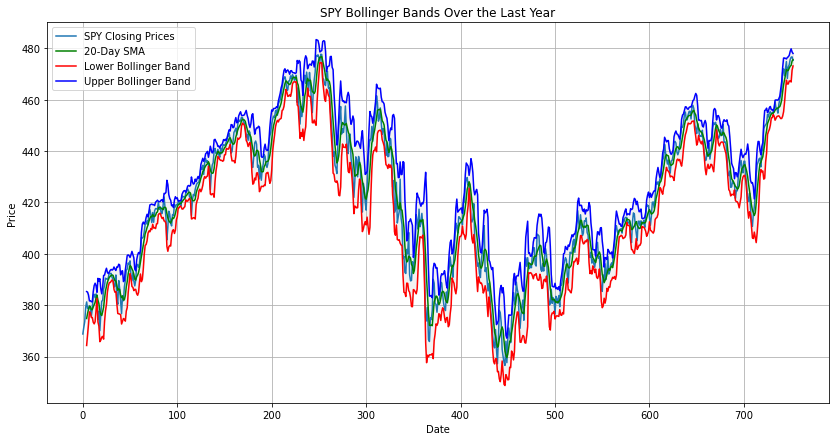

In [3]:
# Calculate Bollinger Bands
window = 5
data['SMA'] = data['Close'].rolling(window=window).mean()
data['STD'] = data['Close'].rolling(window=window).std()
data['Lower Band'] = data['SMA'] - (2 * data['STD'])
data['Lower_bound'] = data.apply(lambda x: min(x['Lower Band'], x['Close'] * 0.99), axis=1)
data['Upper Band'] = data['SMA'] + (2 * data['STD'])

# Plot the data
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='SPY Closing Prices')
plt.plot(data['SMA'], label='20-Day SMA', color='green')
plt.plot(data['Lower Band'], label='Lower Bollinger Band', color='red')
plt.plot(data['Upper Band'], label='Upper Bollinger Band', color='blue')
plt.fill_between(data.index, data['Lower Band'], data['Upper Band'], color='gray', alpha=0.1)
plt.title('SPY Bollinger Bands Over the Last Year')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [16]:
def back_test(data, spy_option_df = pd.read_csv('spy_options_data.csv', index_col=0), s='Lower Band', a=0.98):
    option_df = spy_option_df[['Date', 'K', 'Price']].copy()
    option_df.columns = ['date', 'strike_price', 'put_price']
    option_df['date'] = pd.to_datetime(option_df['date'])
    option_df.set_index('date', inplace=True)

    stock_df = data[data["Date"].isin(option_df.index.drop_duplicates())][['Date', s, 'Close']]
    stock_df.columns = ['date', 'threshold_price', 'stock_price']
    stock_df = stock_df.set_index('date')

    stock_prices = data[['Date', 'Close']].copy()
    stock_prices['Date'] = pd.to_datetime(stock_prices['Date'])
    stock_prices.set_index('Date', inplace=True)

    # Calculate the target strike price in stock_df
    stock_df[['threshold_price', 'stock_price']] = stock_df[['threshold_price', 'stock_price']].astype(int)
    stock_df['target_strike'] = stock_df.apply(lambda x: min(x['threshold_price'], x['stock_price'] * a), axis=1).astype(int)
    stock_df['use_threshold'] = stock_df['threshold_price'] < (stock_df['stock_price'] * a)
    
    # Join the dataframes on the date index
    merged_df = stock_df.join(option_df, how='inner')

    # Find the closest strike price for each date in stock_df
    merged_df['strike_diff'] = (merged_df['target_strike'] - merged_df['strike_price']).abs()
    merged_df = merged_df.reset_index()
    min_diff_df = merged_df.loc[merged_df.groupby('date')['strike_diff'].idxmin()].set_index('date')
    # Filter for only Fridays
    friday_df = min_diff_df[min_diff_df.index.weekday == 4]

    # Initial conditions
    initial_capital = 1000000
    account_balance = initial_capital
    contract_multiplier = 100  # Standard option contract multiplier
    margin_requirement_per_contract = 1

    # Initialize results storage
    results = []

    for date, row in friday_df.iterrows():
        strike_price = row['strike_price']
        way = row['use_threshold']
        # strike_price = int(min(row['strike_price'], row['stock_price'] * 0.98))
        put_price = row['put_price'] 
        # Calculate number of contracts based on margin available
        num_contracts = int((account_balance * 0.95) / (strike_price * margin_requirement_per_contract * contract_multiplier))
        premium_received = put_price * contract_multiplier * num_contracts
        account_balance += premium_received  # Add premium received
        
        # Assuming the put option expires worthless if the stock price is above the strike on next Friday
        next_friday = date + pd.DateOffset(days=7)
        if next_friday in stock_prices.index and stock_prices.at[next_friday, 'Close'] > strike_price:
            # Option expires worthless, keep premium
            profit_loss = 0
        else:
            # Calculate the loss based on how much in-the-money
            profit_loss = max(0, strike_price - stock_prices.at[next_friday, 'Close']) * contract_multiplier * num_contracts
            account_balance -= profit_loss  # Pay the loss
        
        results.append({
            'date': date,
            'strike_price': strike_price,
            'put_price': put_price,
            'contracts': num_contracts,
            'premium_received': premium_received,
            'profit_loss': profit_loss,
            'account_balance': account_balance,
            'use_threshold': way
        })

    # Convert results to DataFrame for analysis
    results_df = pd.DataFrame(results)

    # Calculate performance metrics
    final_balance = results_df['account_balance'].iloc[-1]
    total_premium_received = results_df['premium_received'].sum()
    total_return = final_balance - initial_capital
    annual_return = (total_return / initial_capital) * (365.0 / results_df['date'].dt.dayofyear.max())  # Normalize to one year

    # Calculate weekly returns for Sharpe Ratio
    results_df['weekly_returns'] = results_df['account_balance'].pct_change()
    mean_weekly_return = results_df['weekly_returns'].mean()
    std_dev_weekly = results_df['weekly_returns'].std()

    # Sharpe Ratio, assuming risk-free rate = 0 for simplification
    sharpe_ratio = (mean_weekly_return / std_dev_weekly) * np.sqrt(52)  # 52 trading weeks in a year
    # total gain
    results_df['total_gain'] = results_df['premium_received'] - results_df['profit_loss']
    # Output results and metrics
    print("Final Account Balance:", final_balance)
    print("Total Gain:", results_df['total_gain'].sum())
    print("Return on Investment (ROI):", (final_balance - initial_capital) / initial_capital * 100, "%")
    print("Annual Return:", annual_return * 100, "%")
    print("Sharpe Ratio:", sharpe_ratio)
    print("Win Rate:", results_df['total_gain'].apply(lambda x: 1 if x>0 else 0).sum()/results_df.shape[0])
    print("Threshold used:", results_df['use_threshold'].sum()/results_df.shape[0])
    return results_df

In [17]:
var_df = pd.read_csv('VaR_strikeprice.csv')
ls = var_df.columns[1:].to_list()
var_df['Date'] = pd.to_datetime(var_df['Date'])
for lb_name in ls:
    print(lb_name)
    _ = back_test(var_df[['Date', lb_name]].merge(data[['Date', 'Close']], on='Date', how='left'), 
                  s=lb_name, 
                  a=999, 
                  spy_option_df=pd.read_csv('spy_options_data_2021_2022.csv'))
    print()

Strike_x1.1
Final Account Balance: 1112855.9114990234
Total Gain: 112855.91149902344
Return on Investment (ROI): 11.285591149902343 %
Annual Return: 11.974537121262664 %
Sharpe Ratio: 2.1543337804910143
Win Rate: 0.6222222222222222
Threshold used: 1.0

Strike_x1.05
Final Account Balance: 1112855.9114990234
Total Gain: 112855.91149902344
Return on Investment (ROI): 11.285591149902343 %
Annual Return: 11.974537121262664 %
Sharpe Ratio: 2.1543337804910143
Win Rate: 0.6222222222222222
Threshold used: 1.0

Strike_x1
Final Account Balance: 1082916.0516357422
Total Gain: 82916.05163574219
Return on Investment (ROI): 8.291605163574218 %
Annual Return: 8.797778734606366 %
Sharpe Ratio: 4.5101959079600835
Win Rate: 0.8888888888888888
Threshold used: 1.0

Strike_x0.95
Final Account Balance: 1025750.0
Total Gain: 25750.0
Return on Investment (ROI): 2.5749999999999997 %
Annual Return: 2.7321947674418605 %
Sharpe Ratio: 5.493938138437055
Win Rate: 1.0
Threshold used: 1.0

Strike_x0.9
Final Account B

In [18]:
atr_df = pd.read_csv('lower_bound(1).csv')
atr_df['Date'] = pd.to_datetime(atr_df['Date'])
_ = back_test(atr_df.merge(data[['Date', 'Close']], on='Date', how='left'), s='Lower_Bound', a=1,
              spy_option_df=pd.read_csv('spy_options_data_2021_2022.csv'))

Final Account Balance: 1065794.0
Total Gain: 65794.0
Return on Investment (ROI): 6.579400000000001 %
Annual Return: 6.579400000000001 %
Sharpe Ratio: 7.170386105787786
Win Rate: 1.0
Threshold used: 1.0


In [21]:
_ = back_test(data, a=0.99, s='Lower_bound',
              spy_option_df=pd.read_csv('spy_options_data_2021_2022.csv'))

Final Account Balance: 1113501.9713134766
Total Gain: 113501.97131347656
Return on Investment (ROI): 11.350197131347656 %
Annual Return: 11.350197131347656 %
Sharpe Ratio: 0.9577092210900366
Win Rate: 0.8380952380952381
Threshold used: 0.8761904761904762
